In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import random
from collections import namedtuple, deque

from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from qnetwork import QNetwork
from experience import Experience, get_fields_from_experiences
from utils import plot_scores

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

seed = 5
random.seed(seed)
torch.manual_seed(seed)
print('Seed:', seed)

Device: cuda:0
Seed: 5


In [4]:
env = UnityEnvironment(file_name='Banana_Linux/Banana.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain name:', brain_name)

env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.vector_observations[0]
print('State example:', state)

state_size = len(state)
print('State size:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Brain name: BananaBrain
Number of agents: 1
Number of actions: 4
State example: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
State size: 37


In [5]:
class ReplayMemory:
    def __init__(self, memory_size, batch_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
    
    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self):
        return random.sample(self.memory, k=self.batch_size)
    
    def __len__(self):
        return len(self.memory)
    
def demo_replay_memory():
    memory = ReplayMemory(memory_size=100, batch_size=10)
    
    for i in range(1000):
        memory.add(i)

    print(memory.sample())
    
demo_replay_memory()

[979, 932, 994, 945, 988, 983, 967, 903, 959, 999]


In [6]:
class ReplayAgent:
    def __init__(self, 
                 state_size, 
                 action_size,
                 memory_size,
                 batch_size, 
                 learn_every,
                 learn_rate,
                 discount_factor,
                 soft_update_factor
                ):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.learn_every = learn_every
        self.discount_factor = discount_factor
        self.soft_update_factor = soft_update_factor

        self.local_model = QNetwork(state_size, action_size).to(device)
        self.target_model = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.local_model.parameters(), lr=learn_rate)
        self.memory = ReplayMemory(memory_size, batch_size)
        
        self.step = 0
    
    def perceive(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.memory.add(experience)
        
        self.step = (self.step + 1) % self.learn_every
        
        if self.step == 0 and len(self.memory) >= self.batch_size:
            self.learn()

    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.local_model.eval()
        
        with torch.no_grad():
            action_values = self.local_model(state)
        
        self.local_model.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self):
        experiences = self.memory.sample()
        states, actions, rewards, next_states, dones = get_fields_from_experiences(experiences, device)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + self.discount_factor * Q_targets_next * (1 - dones)
        # Get expected Q values from local model
        Q_expected = self.local_model(states).gather(1, actions)
        # Compute loss with importance-sampling weights
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update of target model: θ_target = τ*θ_local + (1 - τ)*θ_target
        for target_param, local_param in zip(self.target_model.parameters(), self.local_model.parameters()):
            target_param.data.copy_(
                self.soft_update_factor * local_param.data + (1.0 - self.soft_update_factor) * target_param.data)

Episode 100	Average Score: 0.88
Episode 200	Average Score: 4.58
Episode 300	Average Score: 7.20
Episode 400	Average Score: 10.51
Episode 500	Average Score: 11.85
Episode 570	Average Score: 13.00
Environment solved in 470 episodes!	Average Score: 13.00


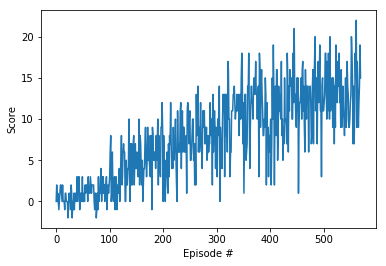

In [7]:
def train(
    agent,
    max_episodes, # (int): maximum number of training episodes
    max_steps, # (int): maximum number of steps per episode
    goal_score, # (int): average score to achive over 100 episodes 
    epsilon_start, # (float): start value of epsilon, for epsilon-greedy action selection
    epsilon_end, # (float): minimum value of epsilon
    epsilon_decay, # (float): multiplicative factor (per episode) for decreasing epsilon
    model_path
):
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    epsilon = epsilon_start # initialize epsilon
    
    for episode in range(1, max_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0 # initialize the score
        
        for step in range(max_steps):
            action = agent.act(state, epsilon)
            
            env_info = env.step(action)[brain_name] # send the action to the environment
            next_state = env_info.vector_observations[0] # get the next state
            reward = env_info.rewards[0] # get the reward
            done = env_info.local_done[0] # see if episode has finished
            
            agent.perceive(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done:
                break
        
        scores_window.append(score) # save most recent score
        scores.append(score) # save most recent score
        epsilon = max(epsilon_end, epsilon_decay * epsilon) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end='')
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
        if np.mean(scores_window) >= goal_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_window)))
            torch.save(agent.local_model.state_dict(), model_path)
            break
    
    return scores

agent = ReplayAgent(
    state_size=state_size, 
    action_size=action_size,
    memory_size=int(1e5),
    batch_size=64,
    learn_every=4,
    learn_rate=5e-4,
    discount_factor=0.99,
    soft_update_factor=1e-3,
)

scores = train(
    agent=agent,  
    max_episodes=600, 
    max_steps=1000, 
    goal_score=13, 
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay=0.995,
    model_path='models/replay_dqn.pth'
)

plot_scores(scores)

In [8]:
def test(agent, epsilon=0.05):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0] # get the current state
    score = 0 # initialize the score

    while True:
        action = agent.act(state, epsilon) # select an action
        env_info = env.step(action)[brain_name] # send the action to the environment
        next_state = env_info.vector_observations[0] # get the next state
        reward = env_info.rewards[0] # get the reward
        done = env_info.local_done[0] # see if episode has finished
        score += reward # update the score
        state = next_state # roll over the state to next time step
        
        if done: # exit loop if episode finished
            break
    
    print("Score: {}".format(score))
    
test(agent)

Score: 10.0


In [9]:
env.close()